In [60]:
import numpy as np
np.random.seed(12345)
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))
np.set_printoptions(precision=4, suppress=True)
import pandas as pd
from pandas import Series, DataFrame, RangeIndex
import seaborn as sns

# Datasets

In [61]:
covid_data = pd.read_csv("https://opendata.ecdc.europa.eu/covid19/vaccine_tracker/csv/data.csv")

In [62]:
covid_data_2 = pd.read_csv("https://covid.ourworldindata.org/data/owid-covid-data.csv")

In [63]:
covid_data_3 = pd.read_csv("https://covid.ourworldindata.org/data/owid-covid-data.csv")
covid_data_mp = covid_data_3[['continent', 'location', 'date', 'total_cases','iso_code']]

In [64]:
policies_data = pd.read_csv("https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning:

Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.



In [65]:
int_stat = ['Hungary','Italy','Finland']

# Functions 

In [66]:
def xticks_details(xticks,ax,step,rotation):
  if step != 0:
    ax.set_xticks(range(0,len(xticks),step))
    ax.set_xticklabels(xticks[0:len(xticks):step], rotation=rotation)
  else:
    ax.set_xticks(range(len(xticks)))
    ax.set_xticklabels(xticks)

In [67]:
def get_outliers_labels(df, list_of_values = None):
  label=[]
  if list_of_values != None:
    for value in list_of_values:
      i = np.where(df['people_fully_vaccinated_per_hundred'] == value)
      a = df.iloc[i].index.get_level_values('location')
      label.extend(list(a))
  return label

In [68]:
def distribution_analysis(vars, graph_title, get_out_names = None):
  fig = plt.figure(figsize = (18,5))
  title = ('Distribution of vaccinated people (percentage) {}'.format(graph_title))
  fig.suptitle(title, fontsize = 20, color='maroon')
  ax= fig.add_subplot(1,2,1)
  vars.hist(bins=30, ax = ax, grid = False, color='grey')
  ax.set_xticks(range(0,100,5))
  ax.set_yticks(range(0,16,1))
  ax.vlines(vars.mean(), ymin=0, ymax=15, color='limegreen', label='average')
  ax.vlines(vars.median(), ymin=0, ymax=15, color='red', label='median')
  ax.legend(loc='best')
  ax2 = fig.add_subplot(1,2,2)
  boxplt = plt.boxplot(vars['people_fully_vaccinated_per_hundred'])
  out = list(boxplt["fliers"][0].get_data()[1])
  if len(out) != 0:
    outliers = get_outliers_labels(vars, list_of_values = out)
    new = list(zip(out,outliers))
    for coord,name in new:
      ax2.annotate(name, xy=(1, coord), xytext=(1.01, coord))
  if get_out_names != None and len(out) != 0:
    return print('Outliers: ', outliers)

In [69]:
def make_linear_regression (df,x_name,y_name):
  from sklearn.linear_model import LinearRegression
  data = df[[x_name,y_name]].dropna()
  x = np.array(np.log(data[x_name])).reshape(-1,1)
  y = np.array(np.log(data[y_name])).reshape(-1,1)
  model = LinearRegression(fit_intercept=True).fit(x, y)
  return model.coef_

def coeff_df (df, loc_col, state, y_vars, x_name):
    beta = []
    y_fin = []
    for y in y_vars:
      try:
        coef = make_linear_regression(df[df[loc_col]== state], x_name = x_name, y_name=y)
        beta.append(round(float(coef),3))
        y_fin.append(y)
      except:
        continue
    obj = {'Dependant_variables':y_fin,'Beta_hat': beta} 
    return pd.DataFrame(obj)

In [70]:
def subclass_plot(int_vars, list_states, index_name):
  fig = plt.figure(figsize = (28,48))
  title = ("Analysis of subcategories of {} in each country"). format(index_name)
  fig.suptitle(title, fontsize = 20, color='maroon')
  i=1
  while i < len(int_vars.columns):
    for el in list(int_vars.keys()):
      ax = fig.add_subplot(5,2,i)
      ax.set_title(el, color = 'maroon', fontsize = 15)
      obj = int_vars.loc[list_states,:].reset_index().groupby('CountryName').apply(lambda x: x.groupby(pd.Grouper(key ='Date', freq='1M')).mean())
      obj.reset_index().set_index(['Date','CountryName']).unstack()[el].plot.bar(legend =True, ax=ax, color = ['tab:blue','tab:olive','tab:red'])
      xticks = list(obj.reset_index().set_index(['Date']).index.unique().date)
      xticks_details(xticks,ax,0,90)
      ax.legend(loc='best')
      i+=1

# General overview of pandemics

#### Mapping incidence of pandemic


In [71]:
# 'covid map' dataframe is created in Datasets section
covid_map = covid_data_mp.rename(columns={
    'location': 'country',
    'total_cases': 'cases'
})
covid_map.dropna(inplace = True)
covid_map['date'] = pd.to_datetime(covid_data_mp['date'], format='%Y-%m-%d')

In [72]:
# the code computes the map considering the day before it is launched 
from datetime import datetime, timedelta
int_date = datetime.strftime(datetime.now() - timedelta(1), '%Y-%m-%d')
covid_map_fin = covid_map[covid_map.date == int_date]
covid_map_fin.sample(10)

,continent,country,date,cases,iso_code
60292,South America,Falkland Islands,2022-06-24,1807.0,FLK
81155,Europe,Iceland,2022-06-24,192991.0,ISL
123047,Africa,Namibia,2022-06-24,169007.0,NAM
143607,Europe,Portugal,2022-06-24,5120970.0,PRT
90582,Asia,Japan,2022-06-24,9210607.0,JPN
61169,Oceania,Fiji,2022-06-24,65465.0,FJI
62930,Europe,France,2022-06-24,30574230.0,FRA
47635,Europe,Denmark,2022-06-24,3161148.0,DNK
41721,Africa,Cote d'Ivoire,2022-06-24,82953.0,CIV
147020,Europe,Russia,2022-06-24,18144007.0,RUS


In [73]:
import plotly.express as px
fig = px.scatter_geo(
    covid_map_fin, 
    locations = 'iso_code',
    color = 'continent',
    hover_name = 'country',
    size = 'cases',
    projection = "equirectangular",
    title = f'World COVID-19 Cases for {int_date}'
)
fig.show()

### Countries reaction to the evolution of pandemic

In [74]:
policies_data['Date'] = pd.to_datetime(policies_data['Date'], format='%Y%m%d')

In [75]:
overview_pol = policies_data.set_index(['Date','CountryName']).filter(regex='Display$', axis=1).reset_index().drop(['StringencyLegacyIndexForDisplay'], axis=1)

# in the original dataset are included indices related to the responses of governments to pandemic, but also all their components
# so, I use the regular expression to select only the columns related to the indexes themselves and drop, besides all components, also the legacy index because it is not interesting
# and has the same information load as normal stringency

cases = covid_data_3[['location', 'date', 'new_cases_smoothed']].rename(columns ={'date':'Date','location': 'CountryName','new_cases_smoothed':'daily_cases' })
cases['Date'] = pd.to_datetime(cases['Date'], format='%Y-%m-%d')
new_data = pd.merge(cases,overview_pol, on = ['Date','CountryName']).set_index(['CountryName','Date'])

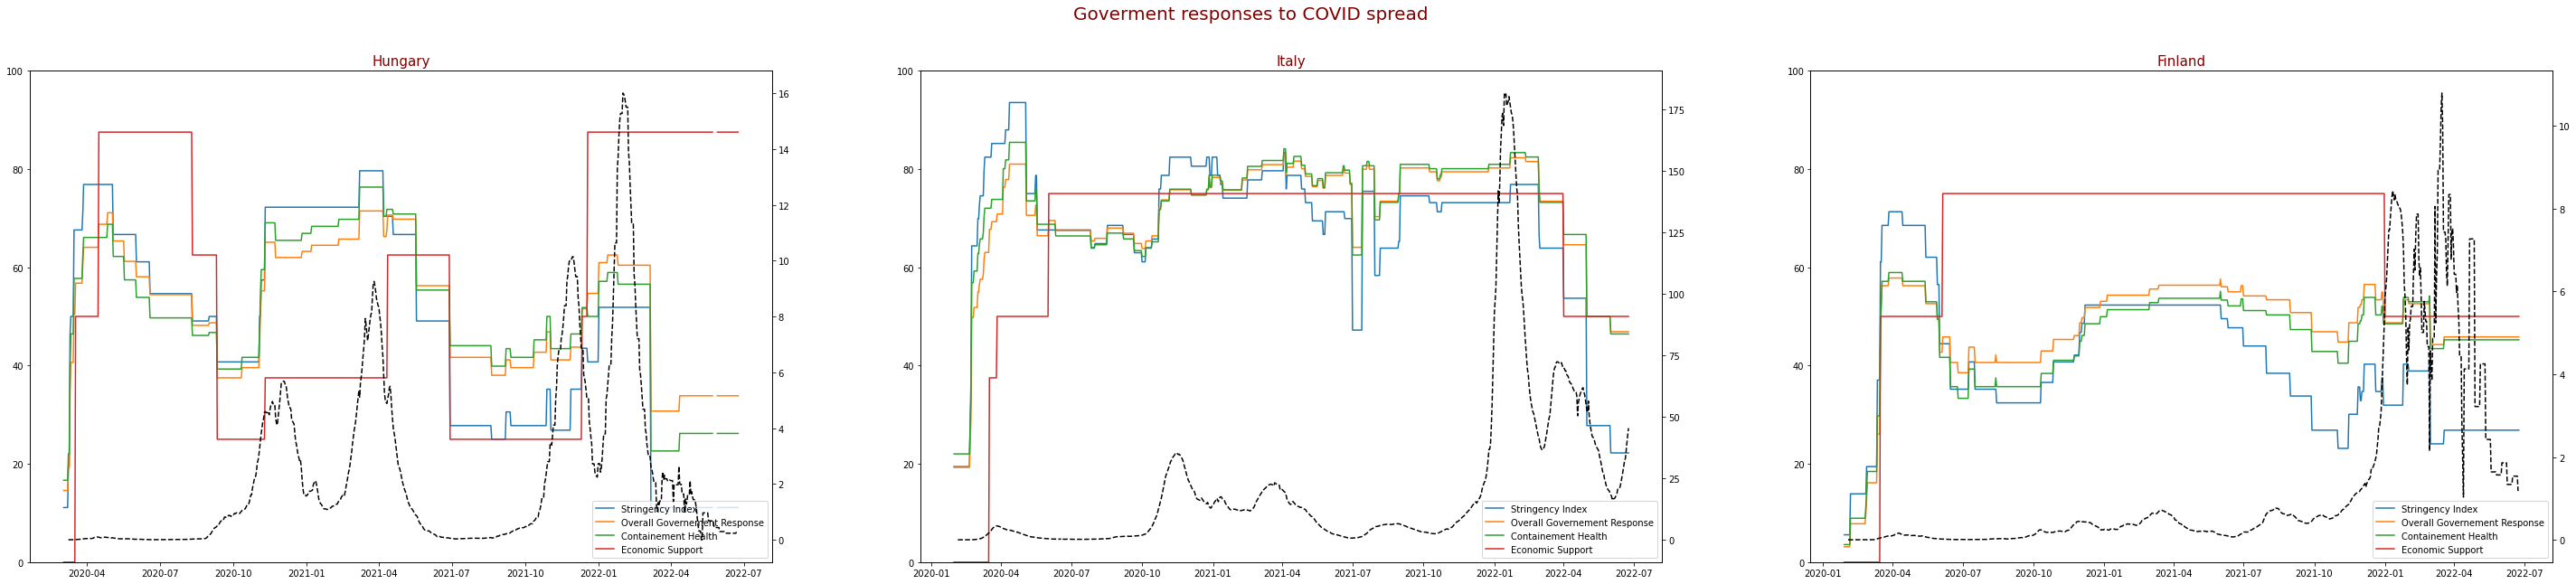

In [76]:
fig = plt.figure(figsize = (50,10))
i=1
fig.suptitle('Goverment responses to COVID spread', fontsize = 20, color='maroon')
for state in int_stat:
    c_foc = new_data.loc[state,:] 
    while i < 4:
      ax = fig.add_subplot(1,3,i)
      ax2 = ax.twinx()
      ax2.plot(c_foc['daily_cases']/(1000), 'k--', label = 'daily cases')
      ax.plot(c_foc.drop(['daily_cases'],axis=1)['StringencyIndexForDisplay'], label ='Stringency Index')
      ax.plot(c_foc.drop(['daily_cases'],axis=1)['GovernmentResponseIndexForDisplay'], label ='Overall Governement Response')
      ax.plot(c_foc.drop(['daily_cases'],axis=1)['ContainmentHealthIndexForDisplay'], label ='Containement Health')
      ax.plot(c_foc.drop(['daily_cases'],axis=1)['EconomicSupportIndexForDisplay'], label ='Economic Support')
      ax.legend(loc='lower right')
      ax.set_ylim([0,100])
      ax.set_title(state, color = 'maroon', fontsize = 15)
      break
    i += 1

Stringency index analysis

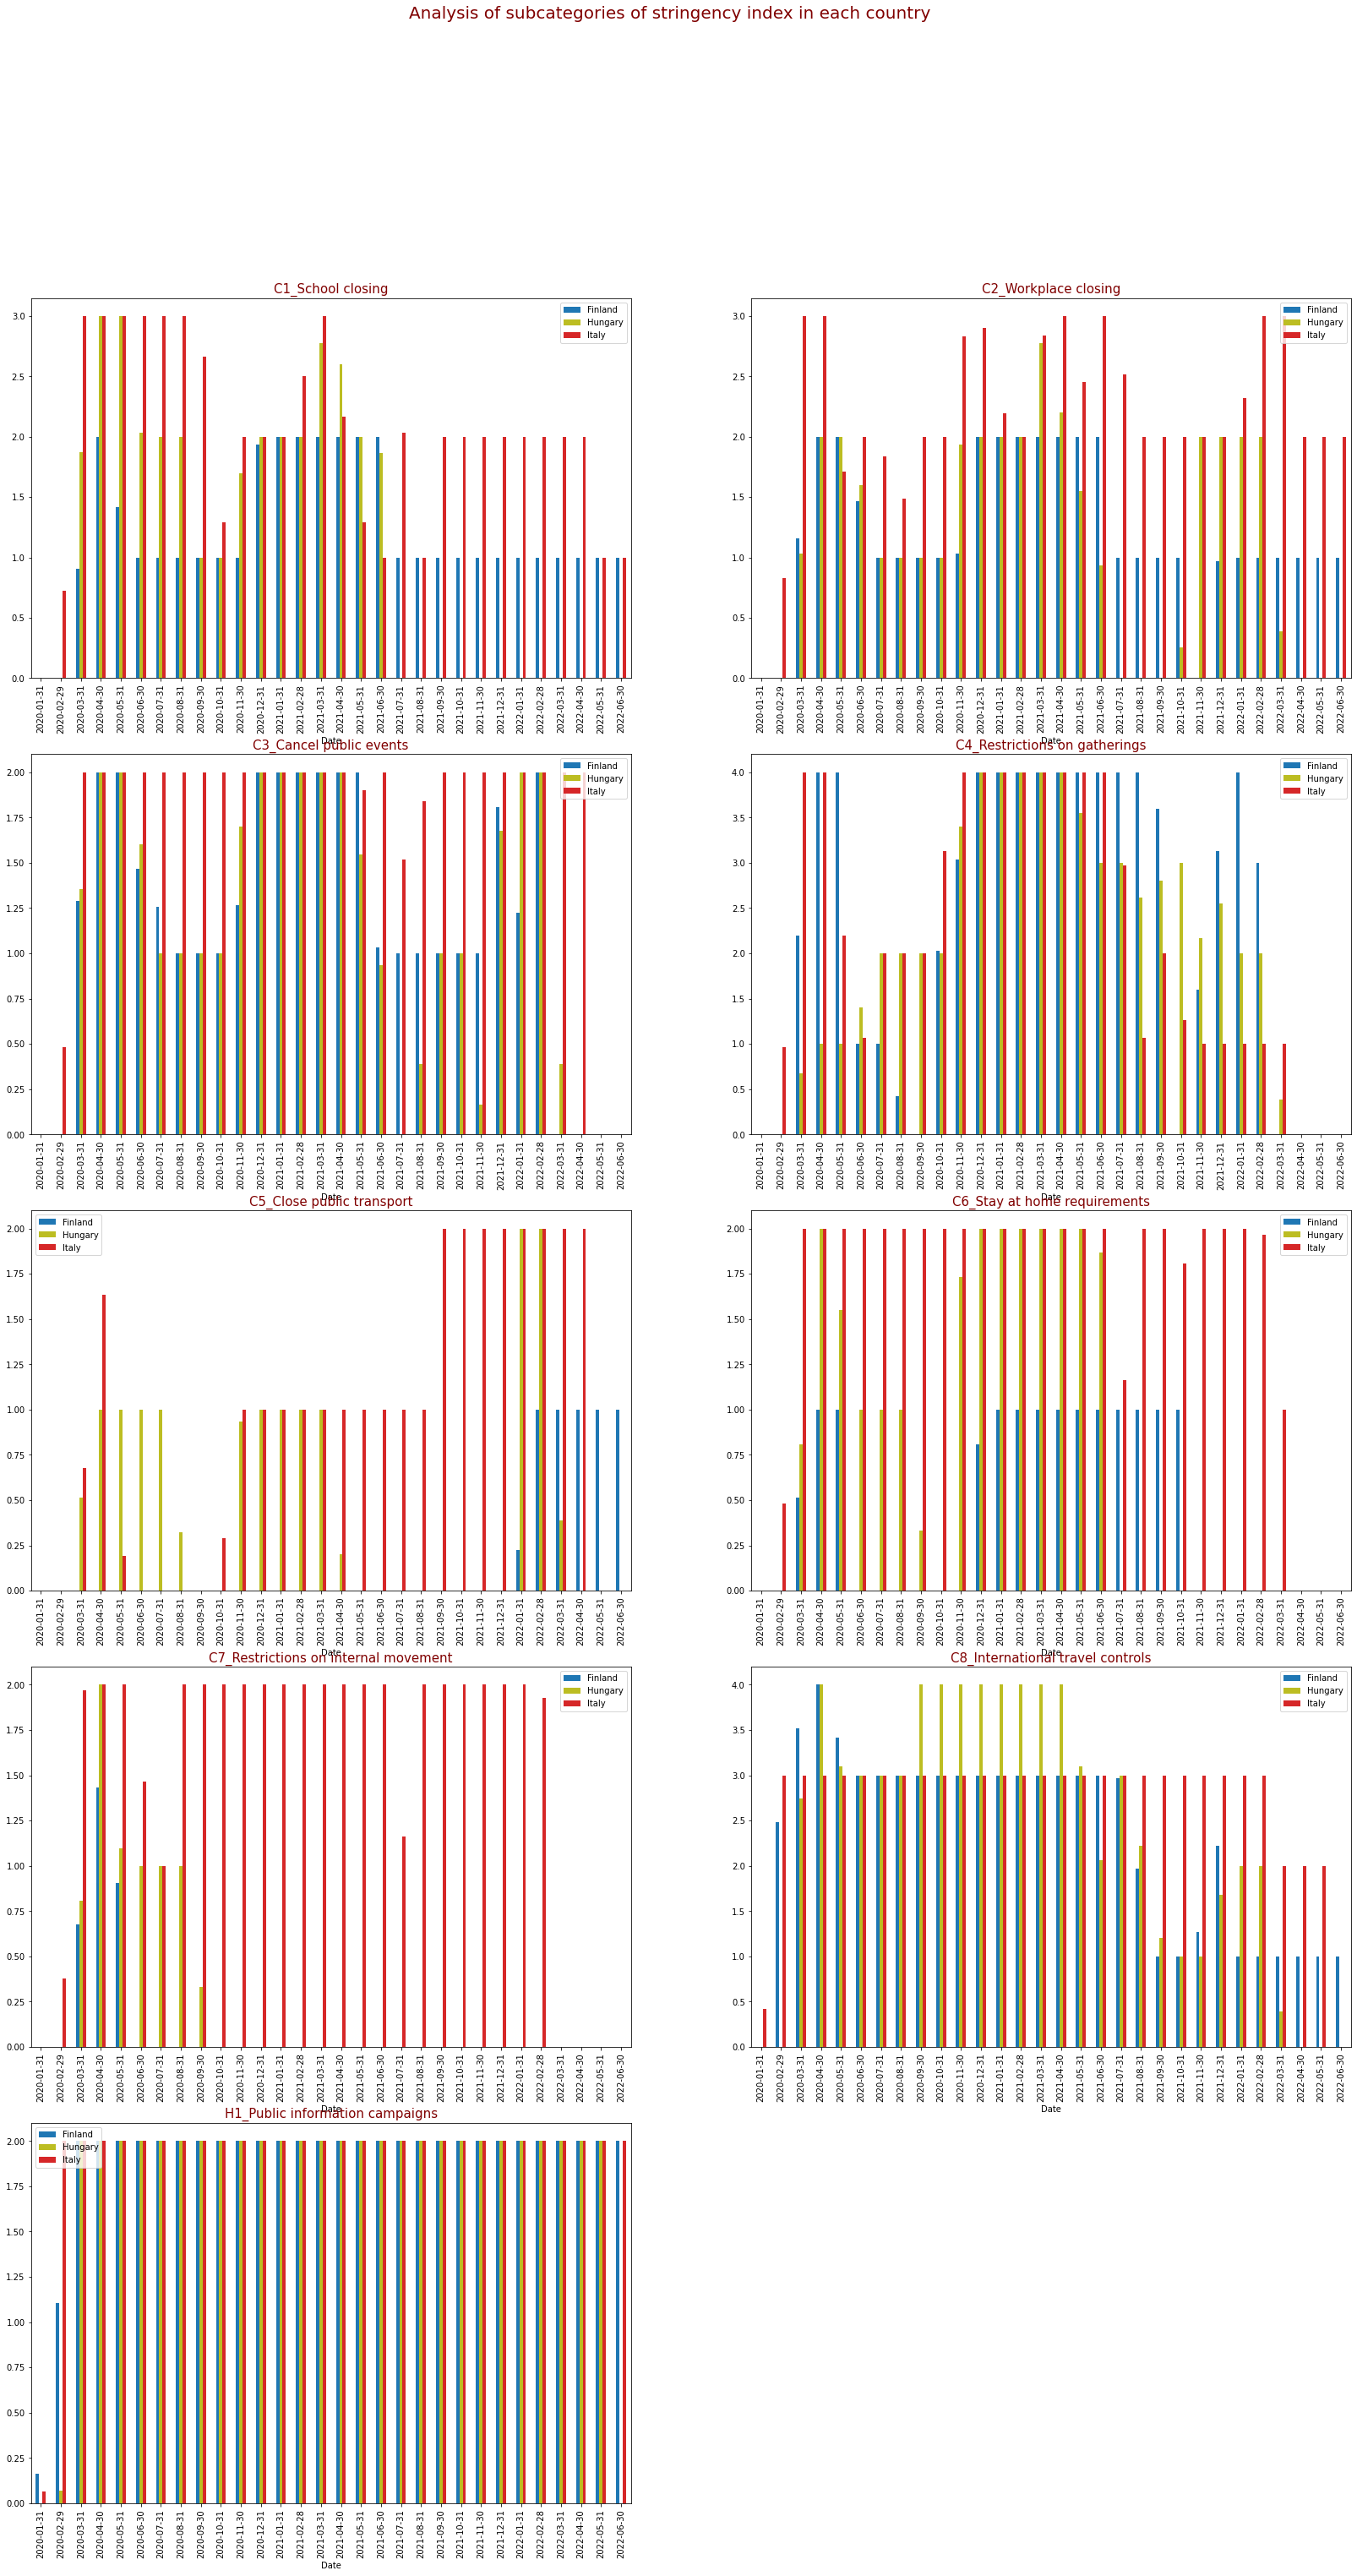

In [77]:
cont_var = policies_data.set_index(['CountryName','Date']).filter(regex='^C[0-9]_[^F]', axis=1) 
# I created a regular expression to find all the columns related to the variables that were used to create the stringency index (variables starting with C, and not an F after the underscore in order to avoid the 'Flag' variables)
oth_var = policies_data[['Date','H1_Public information campaigns','CountryName']].set_index(['CountryName','Date'])
stringency_var = cont_var.join(oth_var)
subclass_plot(int_vars = stringency_var, list_states = int_stat,index_name = 'stringency index')

Economic support Index analysis

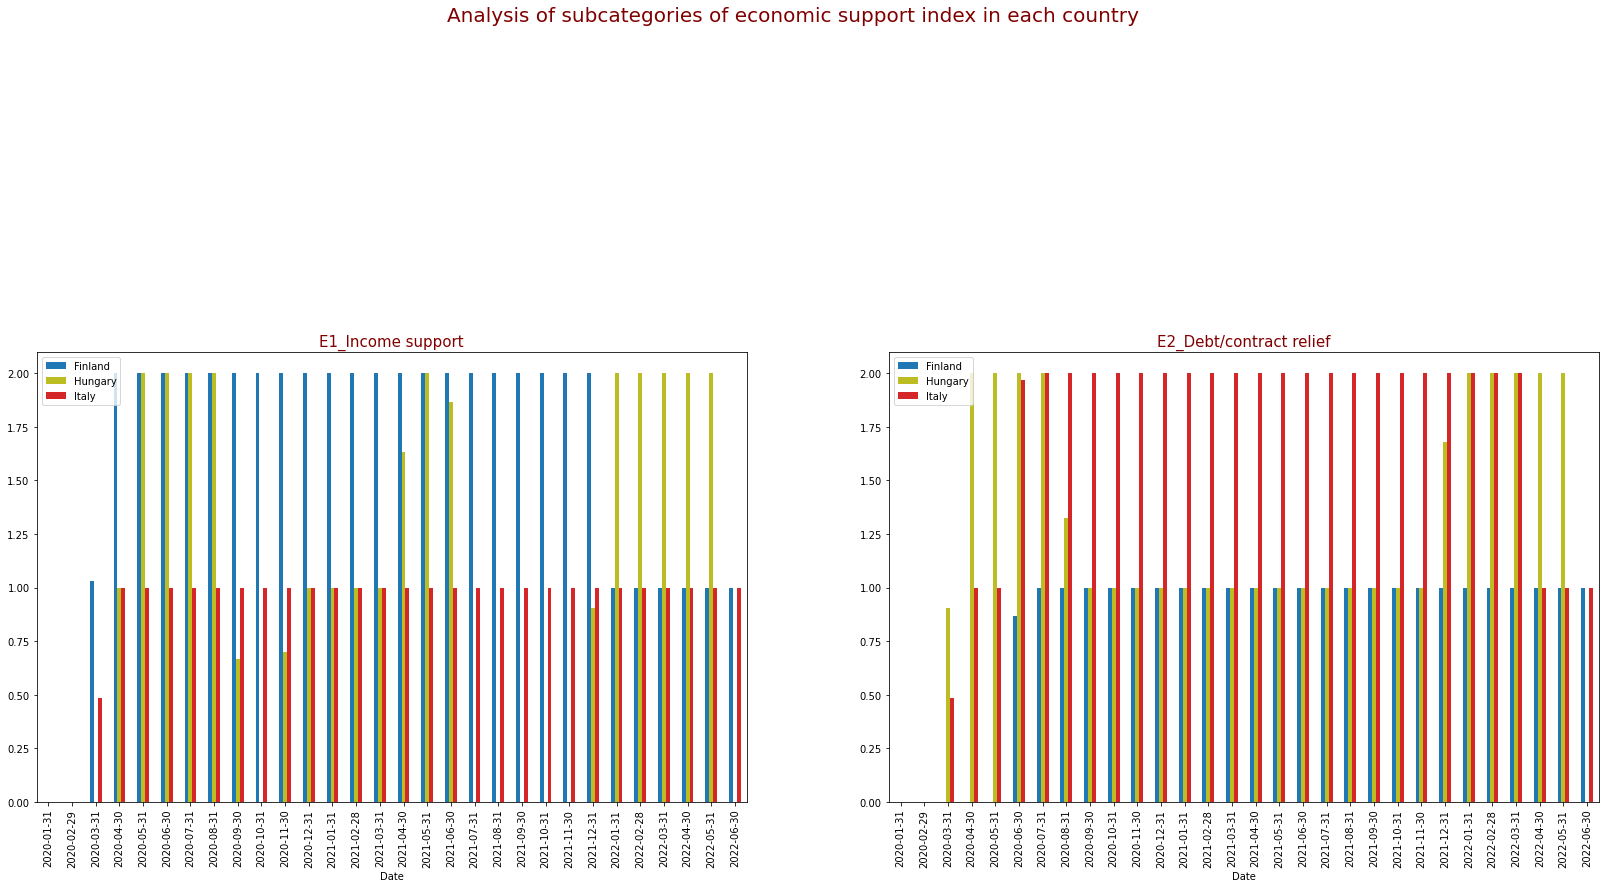

In [78]:
ec_support_var = policies_data[['CountryName','Date','E1_Income support','E2_Debt/contract relief']].set_index(['CountryName','Date'])
subclass_plot(ec_support_var, int_stat, 'economic support index')

# Analysis of vaccines spread 

### World's percentage of vaccinated people

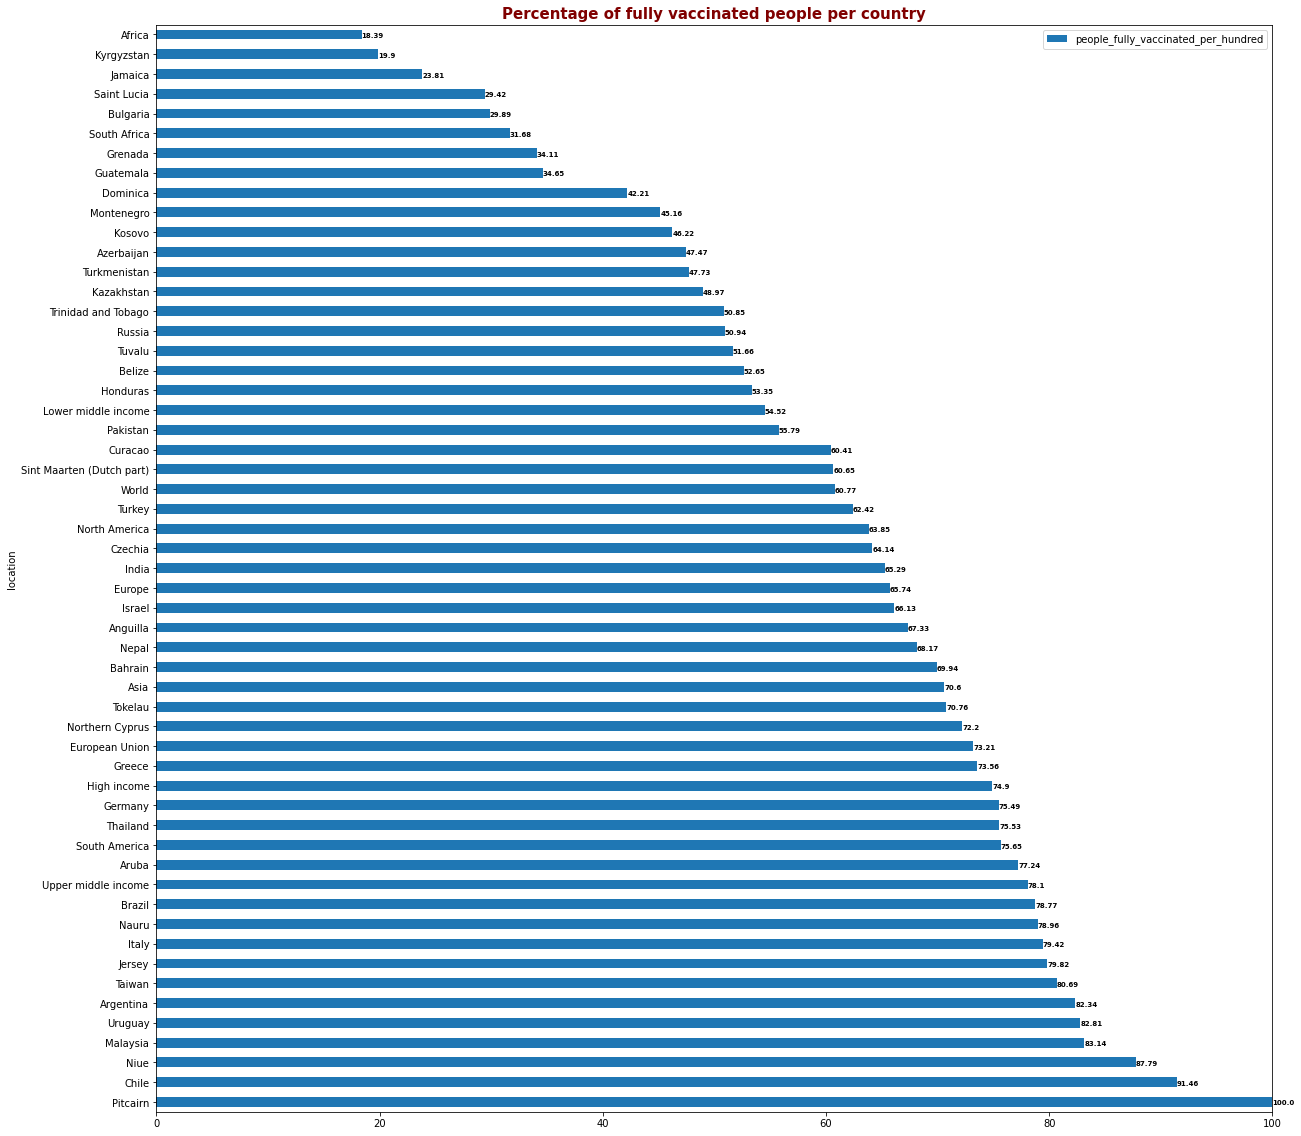

In [99]:
grouped_2 = covid_data_2[['date', 'location','people_fully_vaccinated_per_hundred']].groupby(['location'])
ord_totals= grouped_2.apply(lambda x: (x[['date','people_fully_vaccinated_per_hundred']].iloc[-1])).dropna().sort_values(by='people_fully_vaccinated_per_hundred', ascending=False)
# the programme takes into account the data relative to the week before it is runned; I do so in order to avoid problems related to the different timing of data collection and communication among countries
fig = plt.figure(figsize = (40,40))
ax1 = fig.add_subplot(1,1,1)
graph_1 = ord_totals['people_fully_vaccinated_per_hundred'].plot.barh(figsize=(20,20), ax = ax1)
for i in graph_1.patches:
    plt.text(i.get_width(), i.get_y()+0.1,
             str(round((i.get_width()), 2)),
             fontsize = 7, fontweight ='bold',
             color ='k')
# for each patch in my graph I take as coordinates of the text I'm going to write the width and the y coordinate (increased by 0.1 to centre the value written)
# and as the body of the text I use the length of the bar (which represents the percentage)
graph_1.set_title('Percentage of fully vaccinated people per country', loc='center', fontsize = 15, fontweight ='bold', color='maroon')
plt.xlim(0,100)
ax1.legend()

### Distribution analysis of percentage of vaccinated people across the world

In [80]:
grouped_3 = covid_data_2[['date', 'location','people_fully_vaccinated_per_hundred','continent']].groupby(['continent','location'])
totals_3= grouped_3.apply(lambda x: (x[['date','people_fully_vaccinated_per_hundred']].iloc[-1])).dropna().drop(['date'],axis=1)

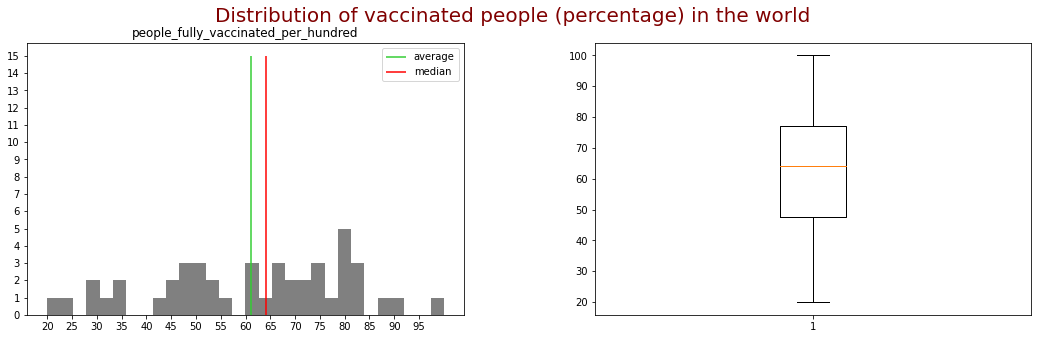

In [81]:
distribution_analysis(totals_3, graph_title='in the world', get_out_names = 'Yes')

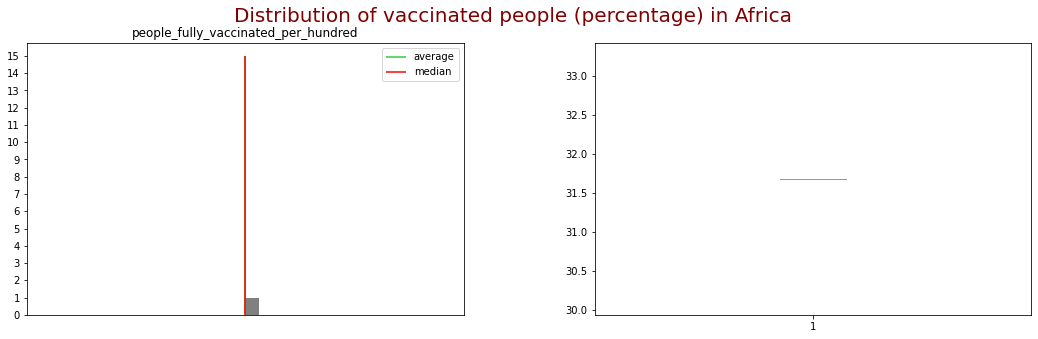

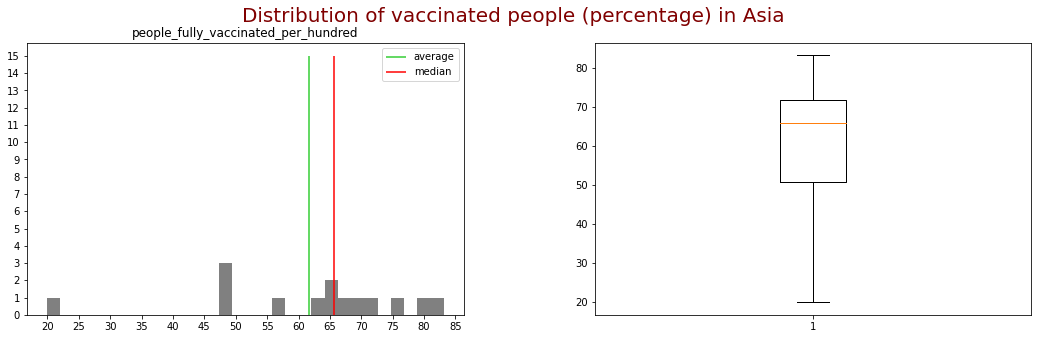

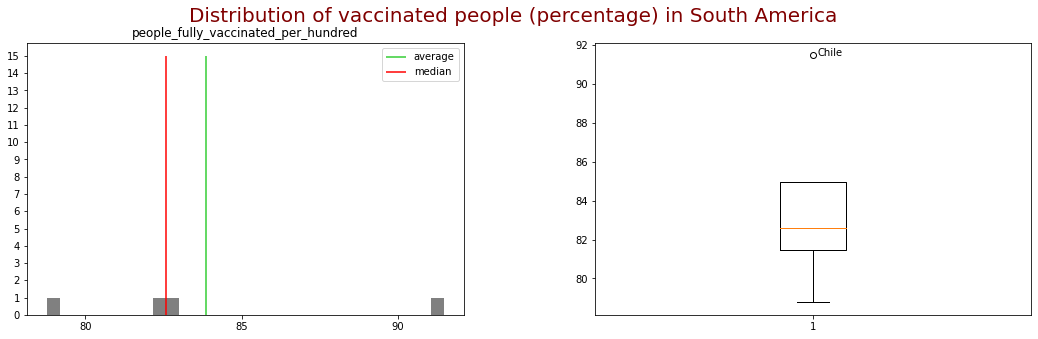

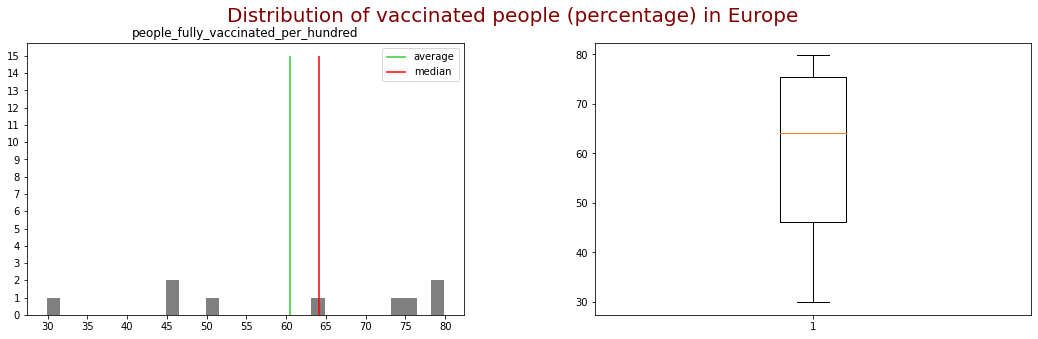

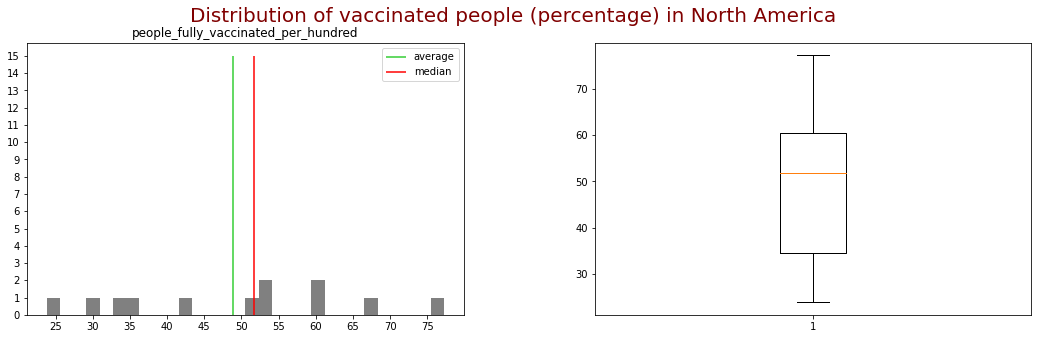

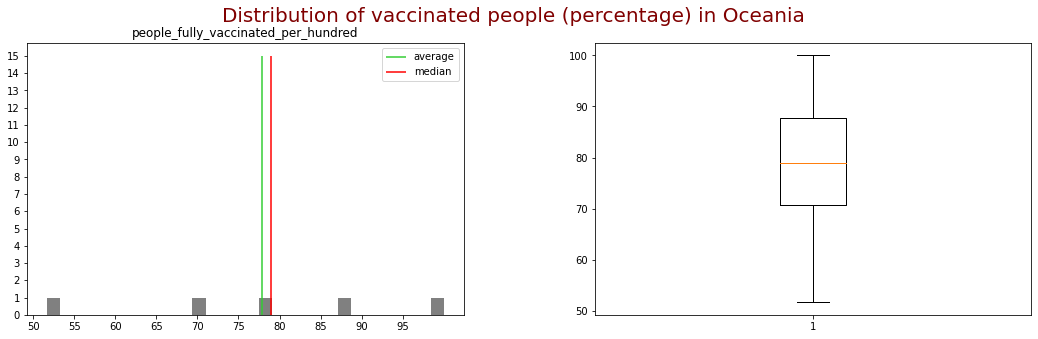

In [82]:
continents = ['Africa', 'Asia','South America','Europe', 'North America', 'Oceania']
for continent in continents:
  ter = totals_3.loc[continent]
  obj = 'in {}'.format(continent)
  distribution_analysis(vars = ter,graph_title = obj)

### Distribution of vaccines among EU by manufacturer

In [83]:
states = covid_data.set_index('ReportingCountry').index.unique()
covid_data_reg = covid_data.set_index('Region').loc[states]
abb_to_name = {'AT': 'Austria', 'BE': 'Belgium', 'BG':'Bulgaria', 'CY':'Cyprus', 'CZ': 'Czech Republic', 'DE': 'Germany', 'DK':'Denmark', 'EE':'Estonia', 'EL':'Greece', 'ES':'Spain', 'FI':'Finland', 'FR':'France',
       'HR':'Croatia', 'HU':'Hungary', 'IE':'Ireland', 'IS':'Iceland', 'IT':'Italy', 'LI':'Liechtenstein', 'LT':'Lituania', 'LU':'Luxembourg', 'LV':'Latvia', 'MT':'Malta', 'NL':'Netherlands', 'NO':'Norway',
       'PL':'Poland', 'PT':'Portugal', 'RO':'Romania', 'SE':'Sweden', 'SI':'Slovenia', 'SK':'Slovakia'}

covid_data_reg['ReportingCountry'] = covid_data_reg['ReportingCountry'].map(abb_to_name)

In [84]:
# dati stock
covid_data_xvacc = covid_data_reg.set_index(['ReportingCountry','YearWeekISO','Vaccine'])
prov = covid_data_xvacc[['NumberDosesReceived','NumberDosesExported','FirstDose','SecondDose','TargetGroup']]
grouped = prov.loc[prov['TargetGroup'] == 'ALL'].groupby(['ReportingCountry','Vaccine']).sum()
# in the dataframe indexed by country, date and vaccine the data relating to each type of vaccine are repeated for all age groups, so if I performed the sum using that dataframe I would overestimate the number of vaccines
# then I extract the group of values related to the age class 'ALL' 
# at that point I recreate the groups considering the number of vaccines by type registered in each individual country and I can add them up for the entire pandemic period 
# arriving at obtaining the total number of vaccines per manufacturer for each category

# number of vaccines in time
covid_data_gen = covid_data_reg.set_index(['TargetGroup']).loc['ALL',:].reset_index()[['YearWeekISO','Vaccine','FirstDose','SecondDose']]
covid_data_gen = covid_data_gen.set_index(['Vaccine'])
covid_data_gen['Total'] = covid_data_gen.sum(axis=1)/1000000
covid_data_gen = covid_data_gen.reset_index().groupby('Vaccine')[['Vaccine','YearWeekISO','Total']]
covid_data_gen = covid_data_gen.apply(lambda x: x.set_index(['YearWeekISO']).cumsum()[['Total']])
vaccines = list(covid_data_gen.index.get_level_values('Vaccine').unique())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning:

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().



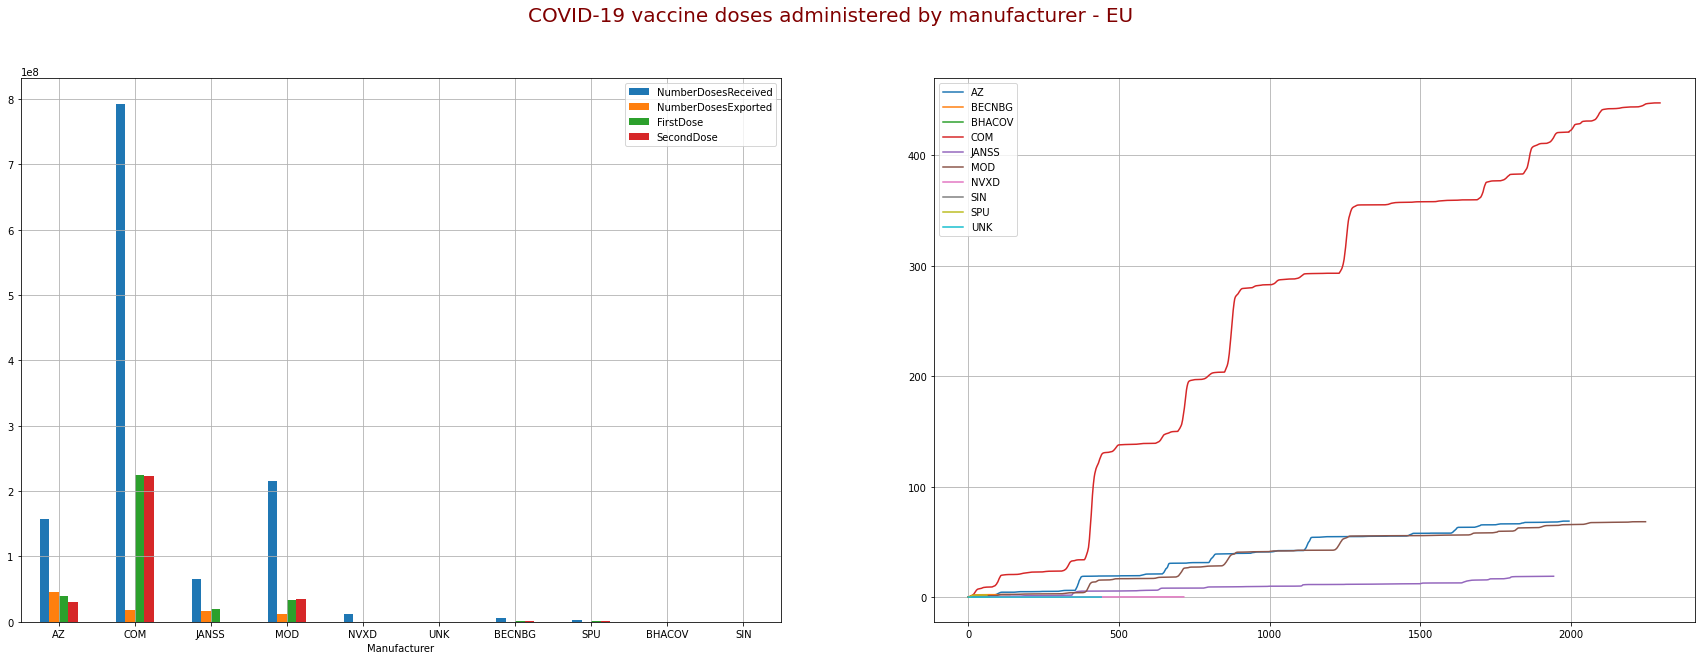

In [85]:
fig = plt.figure(figsize = (30,10))
fig.suptitle('COVID-19 vaccine doses administered by manufacturer - EU', fontsize = 20, color='maroon')
ax = fig.add_subplot(1,2,1)
grouped.sum(level = 'Vaccine').plot.bar(ax = ax, rot = 0)
ax.set_xlabel('Manufacturer', fontsize = 10, color='k' )
ax.grid()
ax1 = fig.add_subplot(1,2,2)
for vaccine in vaccines:
  ter = covid_data_gen.loc[vaccine,:] 
  ax1.plot(ter.values, label = vaccine)
ax1.legend(loc='best')
ax1.grid()

#### Distribution of vaccines by manufacturer in reference countries

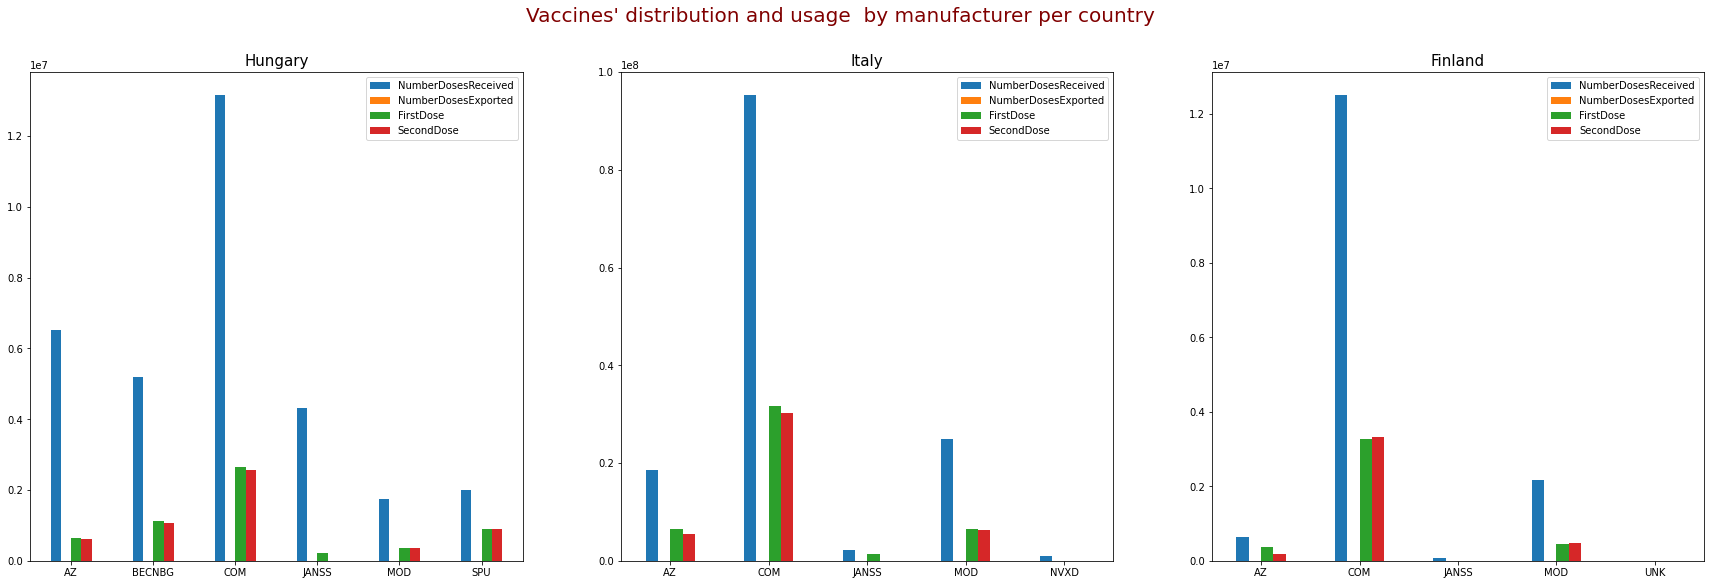

In [86]:
fig = plt.figure(figsize = (30,9))
i=1
fig.suptitle('Vaccines\' distribution and usage  by manufacturer per country', fontsize = 20, color='maroon')
for el in int_stat:
    ter = grouped.loc[el,:] 
    while i < 4:
      ax1 = fig.add_subplot(1,3,i)
      ter.plot(kind = 'bar', ax=ax1, legend='best', rot = 0)
      ax1.set_xlabel('')
      ax1.set_title(el, color='k', fontsize=15)
      break
    i +=1

### Vaccination trends in the reference countries by age group

In [87]:
covid_data_xage = covid_data_reg.groupby(['YearWeekISO','ReportingCountry','TargetGroup']).sum()[['FirstDose','SecondDose']]
# I group the dataframe so as to get the number of doses inoculated weekly in each country for each age group and then create a column in which I record the total number of vaccines inoculated weekly from each country
covid_data_xage['TotalDoses'] = covid_data_xage['FirstDose'] + covid_data_xage['SecondDose']
ages = ['ALL','Age18_24','Age25_49','Age50_59','Age60_69','Age70_79','Age80+','Age<18']

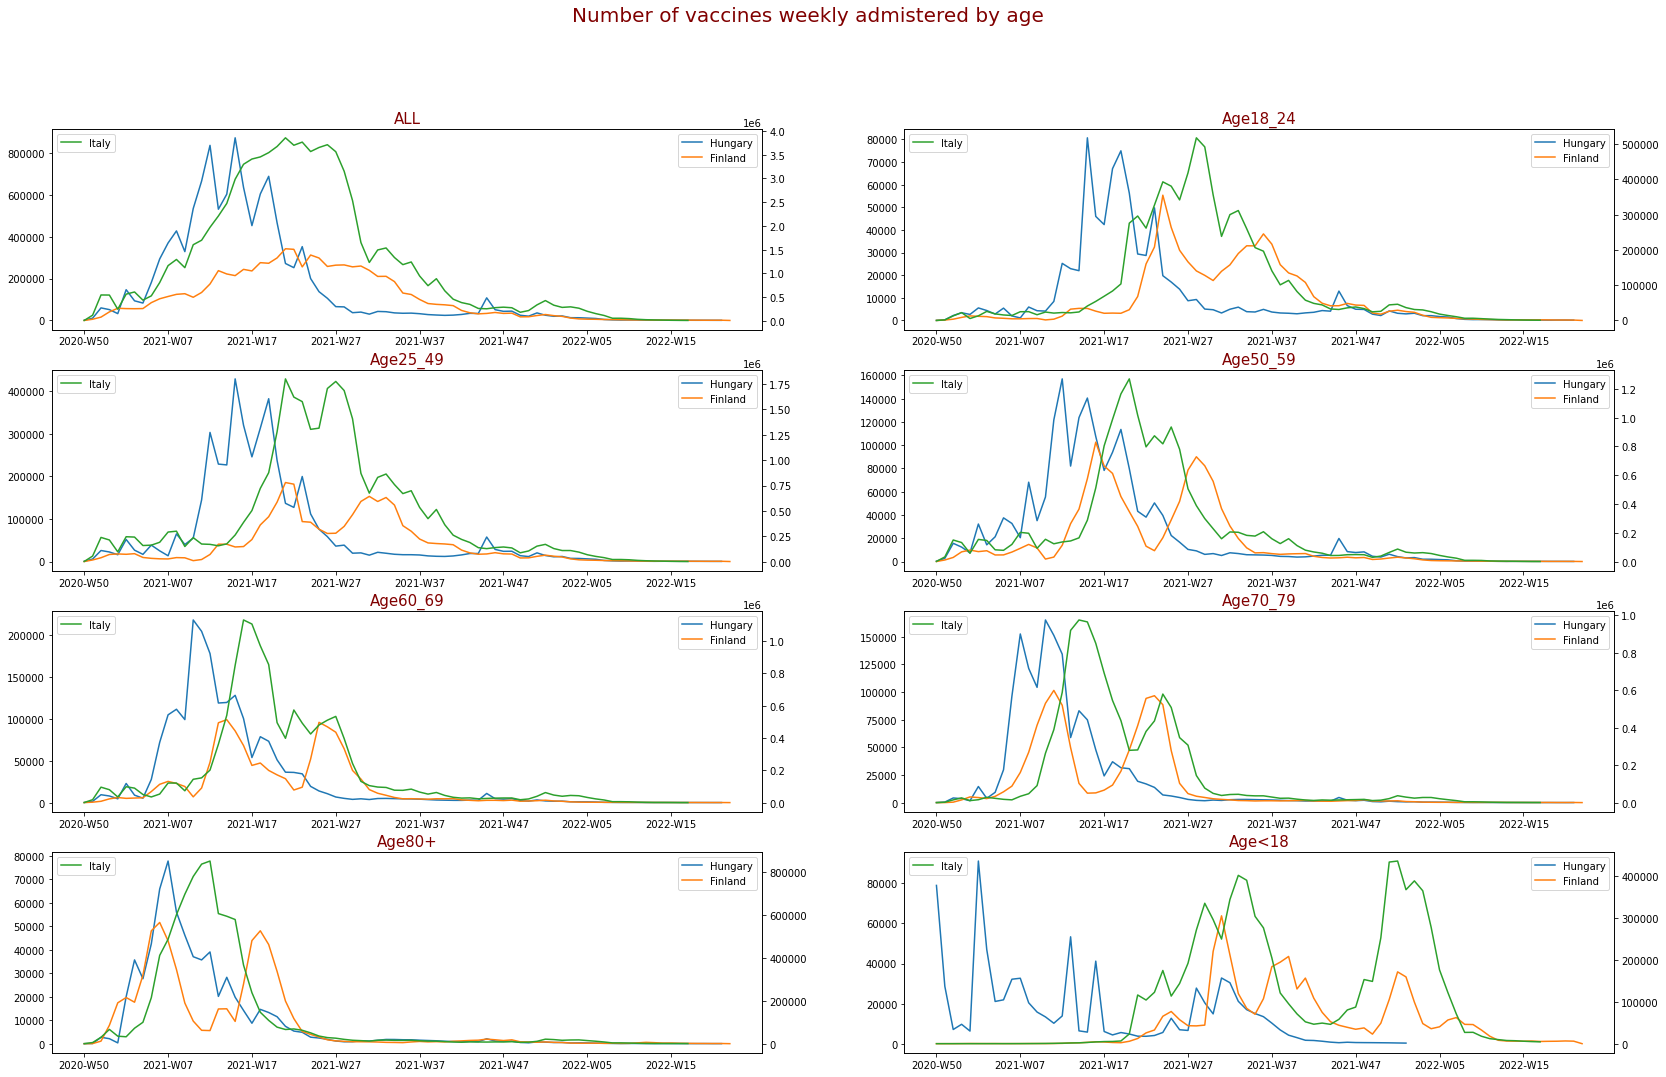

In [88]:
fig = plt.figure(figsize = (28,17))
fig.suptitle("Number of vaccines weekly admistered by age", fontsize = 20, color='maroon')
i=1
xticks = list(covid_data_xage.reset_index(['ReportingCountry','TargetGroup']).index.unique())
while i < 9:
  for age in ages:
    ax = fig.add_subplot(4,2,i)
    ax.set_title(age, color = 'maroon', fontsize = 15)
    xticks_details(xticks,ax,10,0)
    for state in int_stat:
      if state != 'Italy':
        try:
          ter = covid_data_xage.loc[:,state,age][['TotalDoses']]
          ax.plot(ter.values, label = state)
        except:
          continue
      else:
        try:
          ter = covid_data_xage.loc[:,state,age][['TotalDoses']]
          ax2 = ax.twinx()
          ax2.plot(ter.values, label = state, color='tab:green')
        except:
          continue
    ax.legend(loc='best')
    ax2.legend(loc='upper left')
    i+=1

In [89]:
covid_data_xage['Denominator'] = covid_data_reg.groupby(['YearWeekISO','ReportingCountry','TargetGroup']).mean()[['Denominator']]
# In this case the dataframe has the problem that the number of age classes is not fixed over time, but varies. 
# So, to fix the situation I calculate the average of this variable for each individual class and work with that to calculate the percentage of vaccinated people in each band
covid_data_xage['Percentage'] = covid_data_xage['TotalDoses']/covid_data_xage['Denominator']
covid_data_xage_pct = covid_data_xage[['SecondDose','Denominator']]

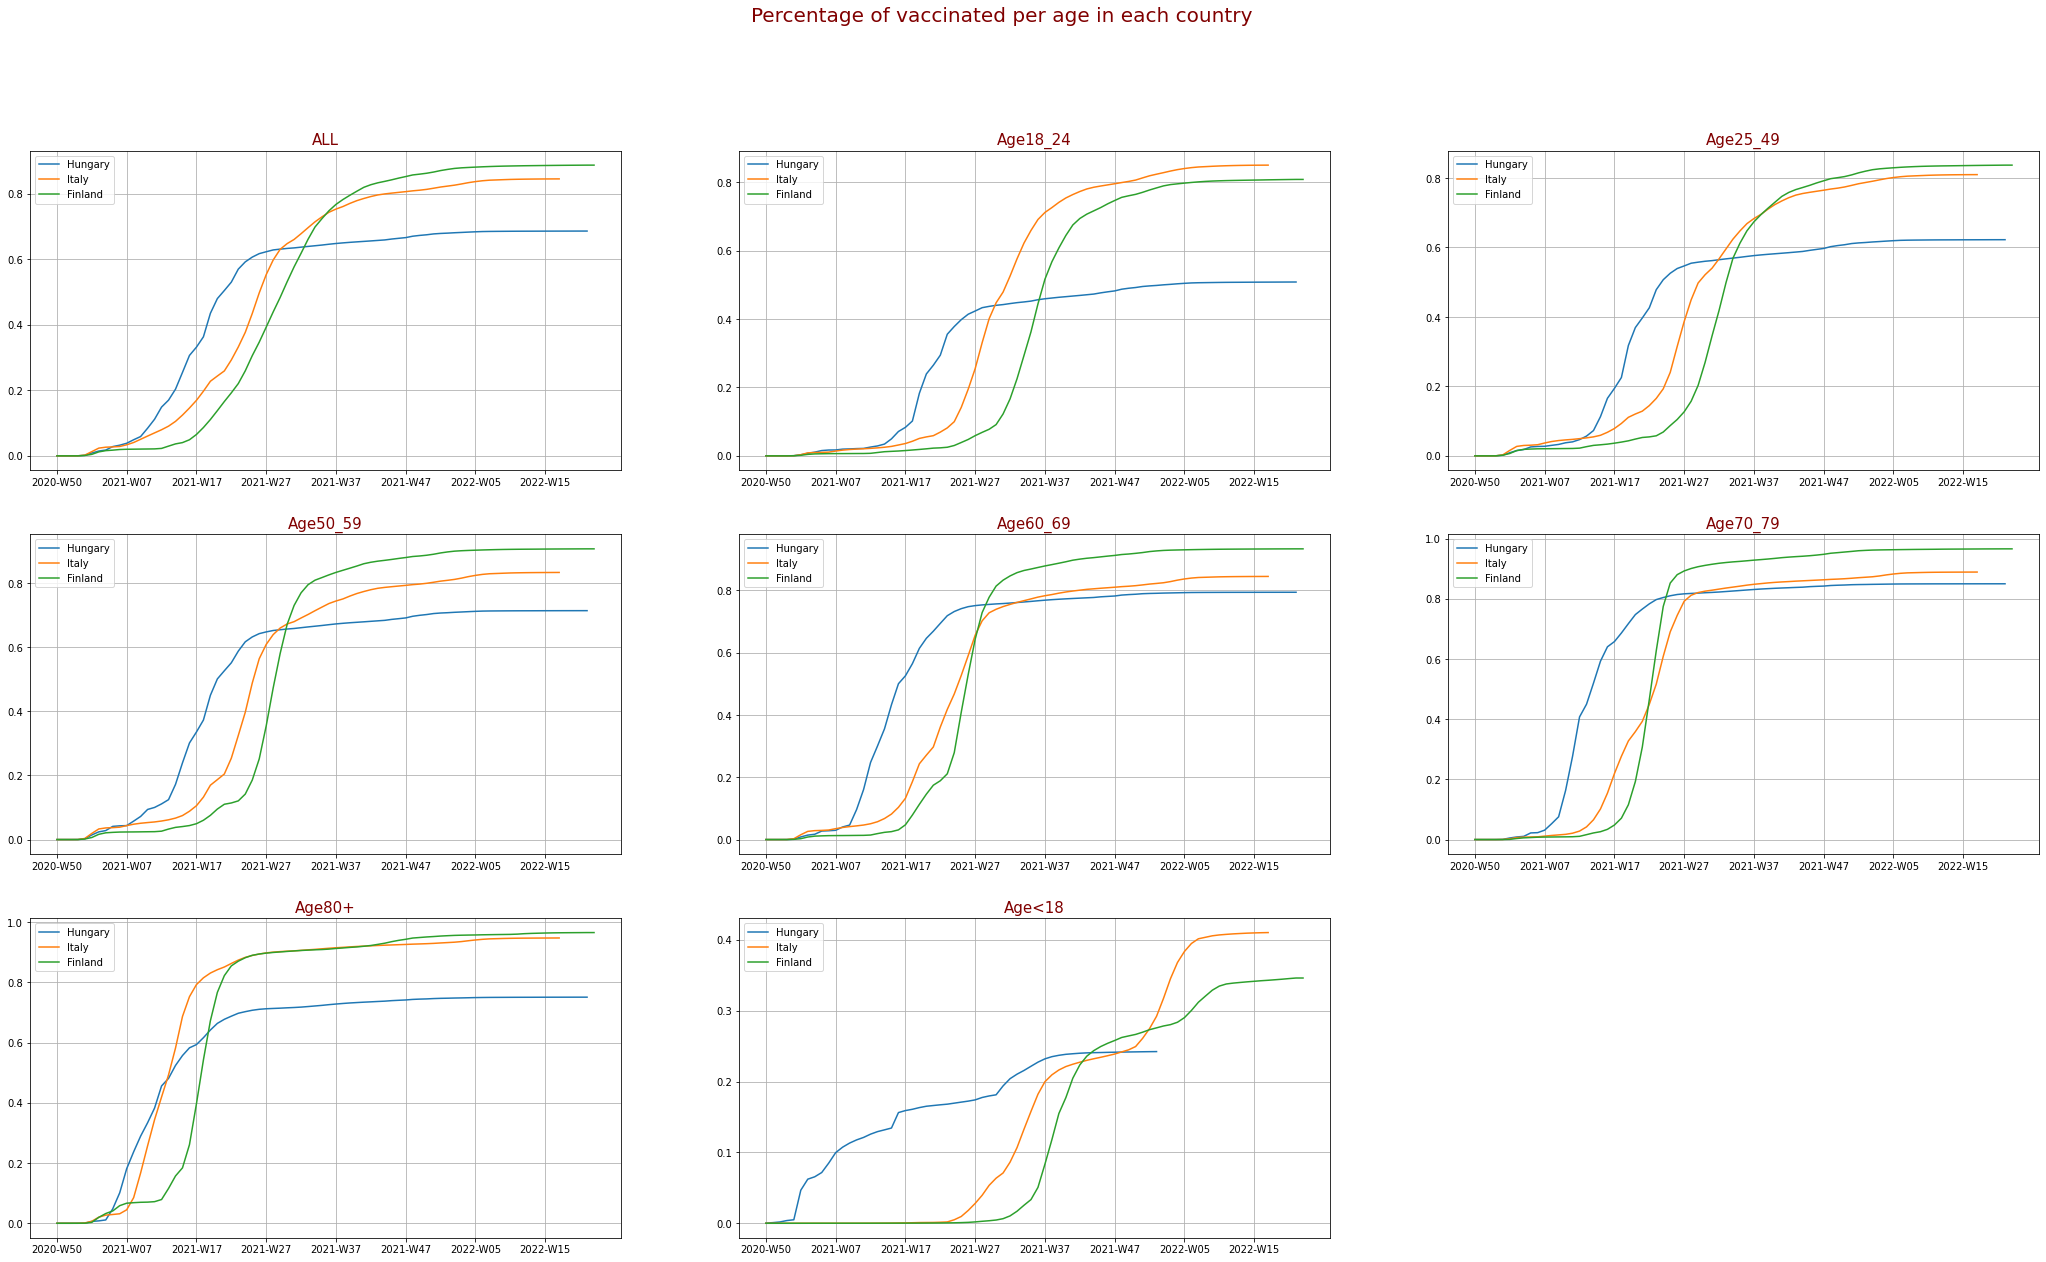

In [90]:
fig = plt.figure(figsize = (36,20))
fig.suptitle("Percentage of vaccinated per age in each country", fontsize = 20, color='maroon')
i=1
while i < 9:
  for age in ages:
    ax = fig.add_subplot(3,3,i)
    ax.set_title(age, color = 'maroon', fontsize = 15)
    xticks_details(xticks,ax,10,0)
    ax.grid()
    for state in int_stat:
      try:
        ter = covid_data_xage_pct.loc[:,state,age].cumsum()['SecondDose'] / covid_data_xage_pct.loc[:,state,age].mean()['Denominator']
        ax.plot(ter.values, label = state)
      except:
        continue
    ax.legend(loc='best')
    i+=1

# Analysis of vaccines' effect

### Effect of vaccinations on some interest variables 


*   analysis of linear regression coefficients




In [91]:
data_since_vacc = covid_data_2.set_index(['continent','location','date']).filter(regex='_per_million$', axis=1).reset_index()
data_since_vacc = data_since_vacc[data_since_vacc['date'] >= '2020-11-15']

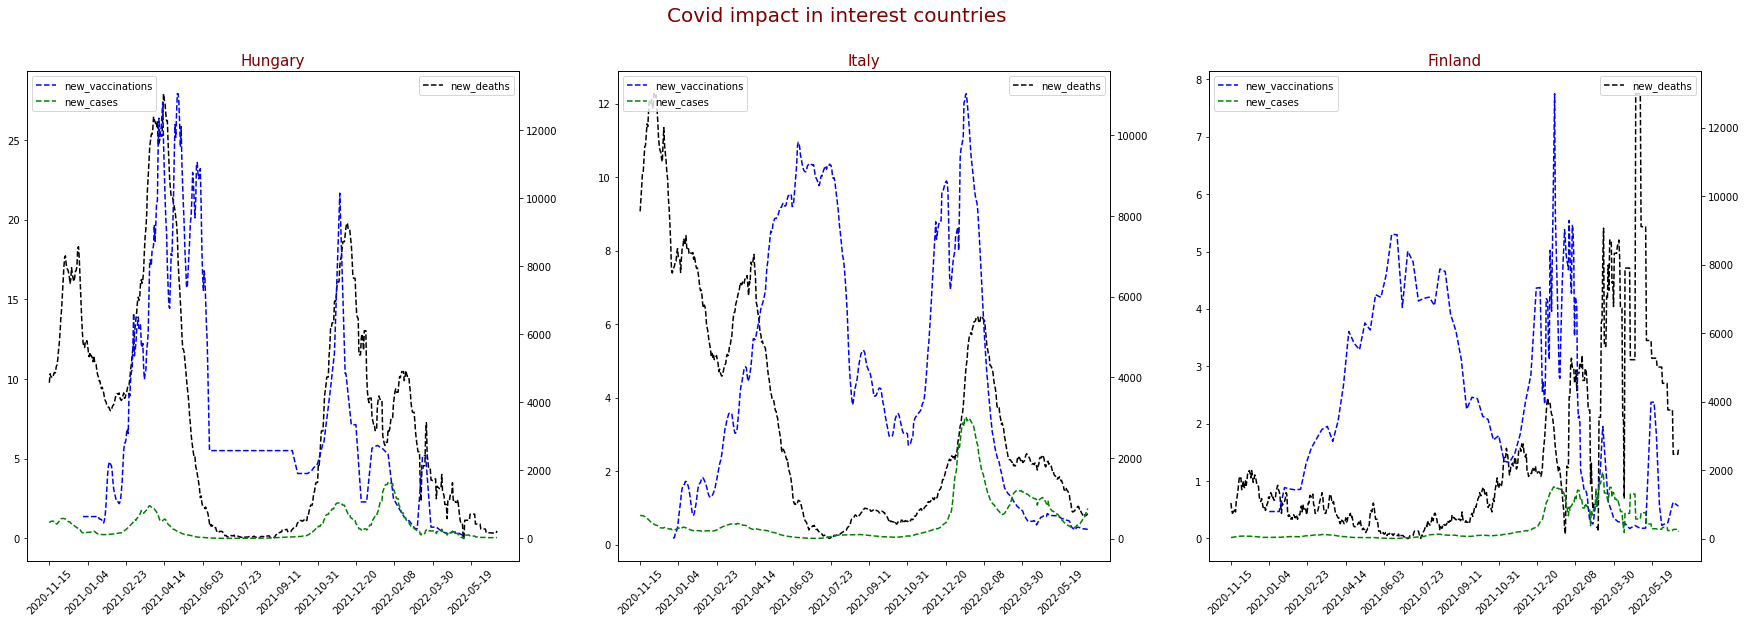

In [92]:
for_graph_1 = data_since_vacc.drop('continent', axis=1).set_index(['location','date']).filter(regex = '^new_.+_smoothed', axis=1)
fig = plt.figure(figsize = (30,9))
xticks = for_graph_1.reset_index('location').index.unique()
i=1
fig.suptitle('Covid impact in interest countries', fontsize = 20, color='maroon')
for state in int_stat:
    ter = for_graph_1.loc[state,:] 
    while i < 4:
      ax = fig.add_subplot(1,3,i)
      ax.plot(ter['new_deaths_smoothed_per_million'],'k--', label ='new_deaths')
      ax2 = ax.twinx()
      ax2.plot(ter['new_vaccinations_smoothed_per_million'], 'b--', label = 'new_vaccinations',)
      ax2.plot(ter['new_cases_smoothed_per_million'],'g--', label ='new_cases')
      ax.legend(loc='upper right')
      ax2.legend(loc='upper left')
      ax.set_title(state, color = 'maroon', fontsize = 15)
      xticks_details(xticks,ax,50,45)
      break
    i += 1

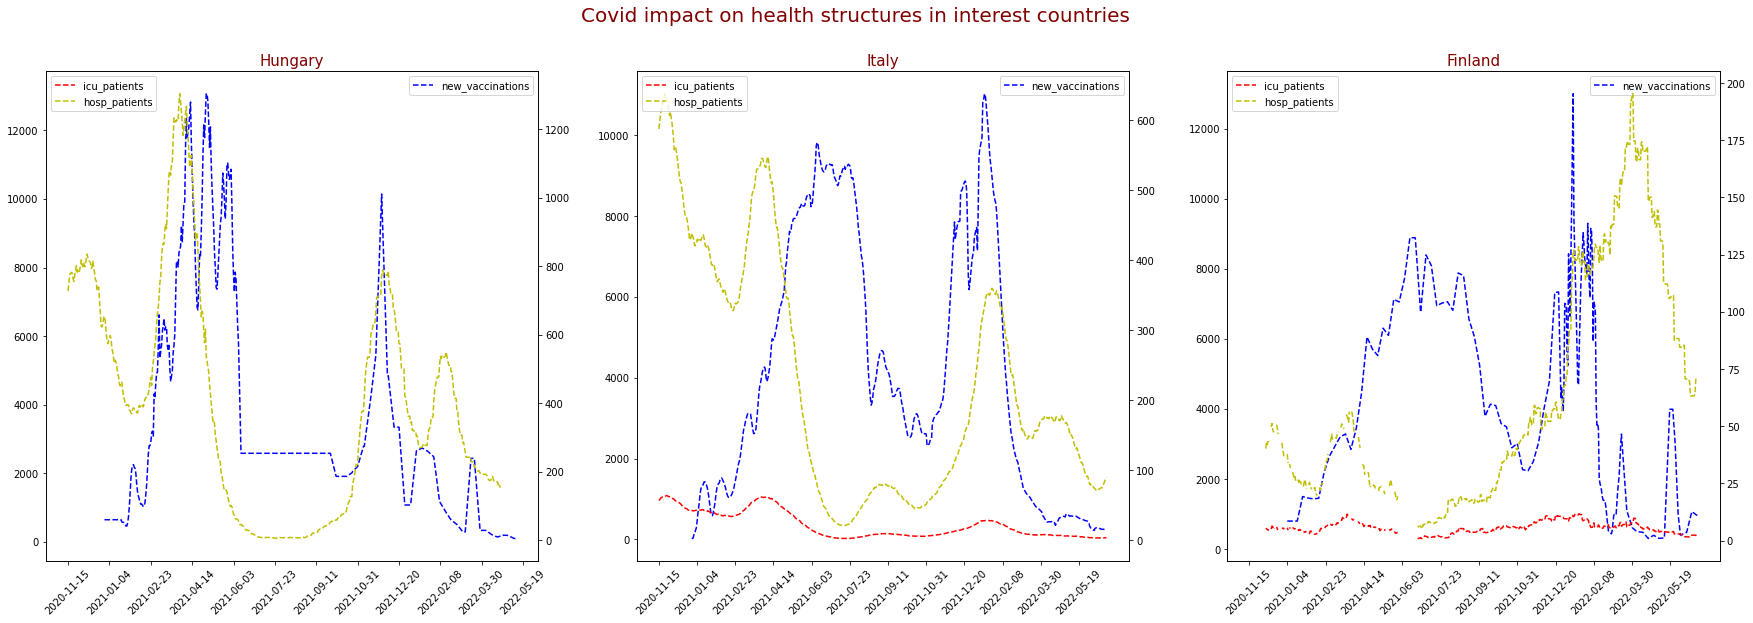

In [93]:
for_graph_2 = data_since_vacc.drop('continent', axis=1).set_index(['location','date']).filter(['icu_patients_per_million','hosp_patients_per_million','new_vaccinations_smoothed_per_million'], axis=1)
fig = plt.figure(figsize = (30,9))
xticks = for_graph_2.reset_index('location').index.unique()
i=1
fig.suptitle('Covid impact on health structures in interest countries', fontsize = 20, color='maroon')
for state in int_stat:
    ter = for_graph_2.loc[state,:] 
    while i < 4:
      ax = fig.add_subplot(1,3,i)
      ax.plot(ter['new_vaccinations_smoothed_per_million'],'b--', label ='new_vaccinations')
      ax2 = ax.twinx()
      ax2.plot(ter['icu_patients_per_million'], 'r--', label = 'icu_patients',)
      ax2.plot(ter['hosp_patients_per_million'],'y--', label ='hosp_patients')
      ax.legend(loc='upper right')
      ax2.legend(loc='upper left')
      ax.set_title(state, color = 'maroon', fontsize = 15)
      xticks_details(xticks,ax,50,45)
      break
    i += 1

In [94]:
import re
y_vars = []
col = list(covid_data_2.columns)
for i in col:
    if re.match('^new_.+_smoothed$|^.+_patients$|^.+[^h]_rate$',i):
        y_vars.append(i)
y_vars = y_vars[:-2]
df_ita = coeff_df(covid_data_2, loc_col='location', state = 'Italy', y_vars = y_vars, x_name = 'new_vaccinations_smoothed')
df_hun = coeff_df(covid_data_2, loc_col='location', state = 'Hungary', y_vars = y_vars, x_name = 'new_vaccinations_smoothed')
df_fin = coeff_df(covid_data_2, loc_col='location', state = 'Finland', y_vars = y_vars, x_name = 'new_vaccinations_smoothed')
df_semi = pd.merge(df_ita,df_hun, on = 'Dependant_variables', suffixes=('_Italy', '_Hungary'))
df_tot = pd.merge(df_semi,df_fin, on = 'Dependant_variables').rename(columns={'Beta_hat': 'Beta_hat_Finland'}).set_index('Dependant_variables')
df_tot.loc['icu_patients'] = [df_ita['Beta_hat'].iloc[3], np.NaN, np.NaN]
# I add the effect of vaccinations on hospitalized in intensive care for Italy --> I think it's interesting
df_tot

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning:

divide by zero encountered in log



,Beta_hat_Italy,Beta_hat_Hungary,Beta_hat_Finland
Dependant_variables,,,
reproduction_rate,0.007,0.021,0.050
hosp_patients,-0.135,0.113,-0.532
new_tests_smoothed,0.112,0.231,0.259
icu_patients,0.115,NaN,NaN
